In [ ]:
from google.colab import drive
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import string
import matplotlib.pyplot as plt

from PIL import Image
import os


In [ ]:
# !unzip "/content/drive/MyDrive/ML-AI Project/Character Recognition Dataset/archive.zip" -d "/content/drive/MyDrive/ML-AI Project/Character Recognition Dataset/Dataset"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
alphabet = list(string.ascii_uppercase)
target = [0,1,2,3,4,5,6,7,8,9]+alphabet
classes = [0,1,2,3,4,5,6,7,8,9]+alphabet+["a","b","d","e","f","g","h","n","q","r","t"]

In [ ]:
def get_relevant_indices(dataset, classes, target_classes):

    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1]
        label_class = classes[label_index]
        if label_class in target_classes:
            indices.append(i)

    return indices
    
def get_data_loader(target_classes, batch_size):

    alphabet = list(string.ascii_uppercase)
    classes = [0,1,2,3,4,5,6,7,8,9]+alphabet+["a","b","d","e","f","g","h","n","q","r","t"]

    transform = transforms.Compose(
        [transforms.ToTensor(),transforms.RandomHorizontalFlip(p=1),transforms.RandomRotation(degrees=(90,90)),transforms.RandomInvert(0.15),
                           transforms.RandomAutocontrast(0.10)])
    

    trainset = torchvision.datasets.EMNIST(root='./data',split = 'balanced', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

    return train_loader, val_loader

def get_test_loader(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),transforms.RandomHorizontalFlip(p=1),transforms.RandomRotation(degrees=(90,90))])
    testset = torchvision.datasets.EMNIST(root='./data',split = 'balanced', train=False,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    
    alphabet = list(string.ascii_uppercase)
    target = [0,1,2,3,4,5,6,7,8,9]+alphabet
    classes = [0,1,2,3,4,5,6,7,8,9]+alphabet+["a","b","d","e","f","g","h","n","q","r","t"]
    relevant_test_indices = get_relevant_indices(testset, classes, target)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              num_workers=1, sampler=test_sampler)
    return test_loader

In [ ]:
target = [0,1,2,3,4,5,6,7,8,9]+alphabet
torch.manual_seed(1000)
train_loader, val_loader = get_data_loader(
    target_classes=target, 
    batch_size=1)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


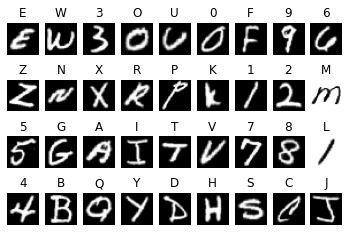

In [ ]:
k = 0
lst = []
for images, labels in train_loader:

    image = images[0]
    image = image.reshape(28,28)
    
    if classes[labels[0]] not in lst:
        # fig.tight_layout(pad=3)
        lst.append(classes[labels[0]])
        plt.subplot(4, 9,k+1)
        plt.title(classes[labels[0]])
        plt.imshow(image,cmap="gray")
        plt.axis('off')
        k+=1
        continue
    if k > 35:
        # print(image)
        break

In [ ]:
class PlateNet1(nn.Module):
   def __init__(self):
      super(PlateNet1, self).__init__()
      self.name = "platenet1"
      self.conv1 = nn.Conv2d(1,10,5)                                     
      self.pool = nn.MaxPool2d(2,2)                 
      self.fc1 = nn.Linear(12*12*10,500)            
      self.fc2 = nn.Linear(500,36)                
      self.dropout = nn.Dropout(0.2)
   def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      # x = self.pool(F.relu(self.conv2(x)))
      # x = F.relu(self.conv3(x))
      x = x.view(-1,12*12*10)
      x = F.relu(self.fc1(self.dropout(x)))
      x = self.fc2(self.dropout(x))
      x = x.squeeze(1)
      return x

In [ ]:
class PlateNet1_noDO(nn.Module):
   def __init__(self):
      super(PlateNet1_noDO, self).__init__()
      self.name = "platenet1_noDO"
      self.conv1 = nn.Conv2d(1,10,5)                                        
      self.pool = nn.MaxPool2d(2,2)                    
      self.fc1 = nn.Linear(12*12*10,500)              
      self.fc2 = nn.Linear(500,36)                   
      # self.dropout = nn.Dropout(0.2)
   def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      # x = self.pool(F.relu(self.conv2(x)))
      # x = F.relu(self.conv3(x))
      x = x.view(-1,12*12*10)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      x = x.squeeze(1)
      return x

In [ ]:
class PlateNet2_noDO(nn.Module):
   def __init__(self):
      super(PlateNet2_noDO, self).__init__()
      self.name = "platenet2_noDO"
      self.conv1 = nn.Conv2d(1,6,3)                                       
      self.pool = nn.MaxPool2d(2,2)                    
      self.conv2 = nn.Conv2d(6,15,3)                    
      self.conv3 = nn.Conv2d(15,25,3)         
      self.fc1 = nn.Linear(9*25*9,100)                 
      self.fc2 = nn.Linear(100,36)                
   def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = x.view(-1,25*9*9)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      x = x.squeeze(1)
      return x

In [ ]:
class PlateNet2(nn.Module):
   def __init__(self):
      super(PlateNet2, self).__init__()
      self.name = "platenet2"
      self.conv1 = nn.Conv2d(1,6,3)                                       
      self.pool = nn.MaxPool2d(2,2)                    
      self.conv2 = nn.Conv2d(6,15,3)                    
      self.conv3 = nn.Conv2d(15,25,3)         
      self.fc1 = nn.Linear(9*25*9,100)                 
      self.fc2 = nn.Linear(100,36)                
      self.dropout = nn.Dropout(0.25)
   def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = x.view(-1,25*9*9)
      x = F.relu(self.fc1(self.dropout(x)))
      x = self.fc2(self.dropout(x))
      x = x.squeeze(1)
      return x

In [ ]:
class PlateNet3(nn.Module):
   def __init__(self):
      super(PlateNet3, self).__init__()
      self.name = "platenet3"
      self.conv1 = nn.Conv2d(1,6,3)                                       
      self.pool = nn.MaxPool2d(2,2)                    
      self.conv2 = nn.Conv2d(6,15,3)                    
      self.conv3 = nn.Conv2d(15,25,3)         
      self.fc1 = nn.Linear(9*25*9,500)
      self.fc2 = nn.Linear(500,100)
      self.fc3 = nn.Linear(100,36)                
      self.dropout = nn.Dropout(0.25)
   def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = x.view(-1,25*9*9)
      x = F.relu(self.fc1(self.dropout(x)))
      x = F.relu(self.fc2(self.dropout(x)))
      x = self.fc3(x)
      x = x.squeeze(1)
      return x

In [ ]:
class PlateNet4(nn.Module):
  def __init__(self):
      super(PlateNet4, self).__init__()
      self.name = "platenet4"
      self.conv1 = nn.Conv2d(1,6,3)                                       
      # self.pool = nn.MaxPool2d(2,2)                    
      self.conv2 = nn.Conv2d(6,15,3)                    
      self.conv3 = nn.Conv2d(15,25,3)         
      self.fc1 = nn.Linear(22*25*22,100)                 
      self.fc2 = nn.Linear(100,36)                
      self.dropout = nn.Dropout(0.25)
  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = x.view(-1,25*22*22)
      x = F.relu(self.fc1(self.dropout(x)))
      x = self.fc2(self.dropout(x))
      x = x.squeeze(1)
      return x

In [ ]:
def get_acc_loss(loader, model):

    correct = 0
    total = 0
    model.eval()
    for input, label in loader:
        # Activate GPU
        if torch.cuda.is_available():
          input = input.cuda()
          label = label.cuda()
        
        output = model(input)
        
        #Compare prediction with actual label
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        # print(correct)
        total += input.shape[0]
    return (correct / total)
    
def get_model_name(name, batch_size, learning_rate):

    path = "model_{0}_bs{1}_lr{2}".format(name,
                                                   batch_size,
                                                   learning_rate)
    return path

In [ ]:
def training(model, batch_size=27, learning_rate=0.001, num_epochs=20):
  torch.manual_seed(1000)
  alphabet = list(string.ascii_uppercase)
  target = [0,1,2,3,4,5,6,7,8,9]+alphabet
  train_loader, val_loader = get_data_loader(target,batch_size)

  criterion = nn.CrossEntropyLoss()

  optimizer = optim.Adam(model.parameters(), lr = learning_rate)


  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  
  for epoch in range(num_epochs):
     correct = 0.0
     total_train_loss = 0.0
     total_epoch = 0
     for i, data in enumerate(train_loader,0):
       # Activate GPU
        input, label = data
        model.train()
        if torch.cuda.is_available():
            input = input.cuda()
            label = label.cuda()
        
        #backwards propagation
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        total_train_loss += loss.item()
        total_epoch += len(label)
     train_acc[epoch] = float(correct) / total_epoch
     train_loss[epoch] = float(total_train_loss)/(i+1)
     val_acc[epoch] = get_acc_loss(val_loader,model) #validation accuracy
     print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch]))
     # Save current model state for access later
  model_path = get_model_name(model.name, batch_size, learning_rate)
  torch.save(model.state_dict(), model_path)
  plt.plot(range(1,len(train_acc)+1), train_acc, label = 'Train')
  plt.plot(range(1,len(train_acc)+1), val_acc, label = 'Validation')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  plt.plot(range(1,len(train_acc)+1), train_loss)
  plt.xlabel("Epoch")
  plt.ylabel("loss")
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

cuda
Epoch 1: Train acc: 0.7004340277777777, Train loss: 0.9953051962044542 |Validation acc: 0.8315972222222222
Epoch 2: Train acc: 0.8608796296296296, Train loss: 0.3930823306816851 |Validation acc: 0.8653935185185185
Epoch 3: Train acc: 0.885402199074074, Train loss: 0.31759987810271323 |Validation acc: 0.8766203703703703
Epoch 4: Train acc: 0.8961660879629629, Train loss: 0.278100134880212 |Validation acc: 0.8825231481481481
Epoch 5: Train acc: 0.9044704861111111, Train loss: 0.2496285161509507 |Validation acc: 0.8912037037037037
Epoch 6: Train acc: 0.9116030092592593, Train loss: 0.22865013039611667 |Validation acc: 0.8848379629629629
Epoch 7: Train acc: 0.9169704861111111, Train loss: 0.2104704115389055 |Validation acc: 0.8885416666666667
Epoch 8: Train acc: 0.9226707175925926, Train loss: 0.19432476988719033 |Validation acc: 0.8949652777777778
Epoch 9: Train acc: 0.9266637731481482, Train loss: 0.1822612263030787 |Validation acc: 0.8866319444444445
Epoch 10: Train acc: 0.92941261

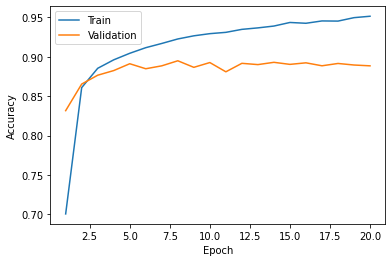

Final Training Accuracy: 0.9515335648148148
Final Validation Accuracy: 0.8885416666666667


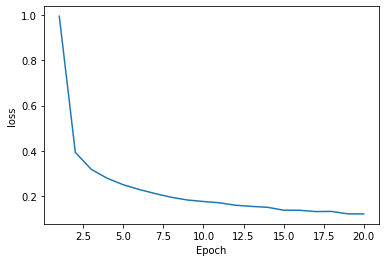

In [ ]:
model = PlateNet1_noDO()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=100, learning_rate=0.0015, num_epochs=20)

cuda
Epoch 1: Train acc: 0.7380642361111112, Train loss: 0.8582600711311908 |Validation acc: 0.8486689814814815
Epoch 2: Train acc: 0.8490740740740741, Train loss: 0.4299407228396807 |Validation acc: 0.8734953703703704
Epoch 3: Train acc: 0.8691261574074074, Train loss: 0.3677211973191686 |Validation acc: 0.8835648148148149
Epoch 4: Train acc: 0.8787037037037037, Train loss: 0.33230338088435935 |Validation acc: 0.8864004629629629
Epoch 5: Train acc: 0.885619212962963, Train loss: 0.30661092267904666 |Validation acc: 0.8903356481481481
Epoch 6: Train acc: 0.8937355324074074, Train loss: 0.28513885602742606 |Validation acc: 0.89375
Epoch 7: Train acc: 0.8980902777777777, Train loss: 0.2710001670427061 |Validation acc: 0.8924189814814815
Epoch 8: Train acc: 0.9012008101851852, Train loss: 0.25567927403170937 |Validation acc: 0.8943287037037037
Epoch 9: Train acc: 0.9044270833333333, Train loss: 0.2467405104395971 |Validation acc: 0.897974537037037
Epoch 10: Train acc: 0.908203125, Train l

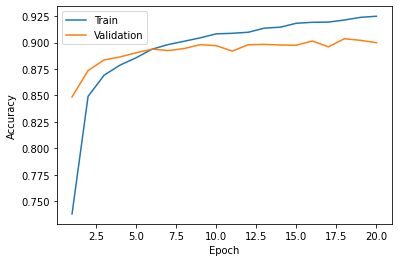

Final Training Accuracy: 0.9248408564814815
Final Validation Accuracy: 0.8998263888888889


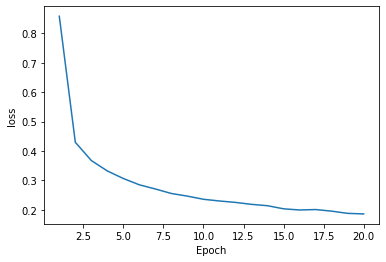

In [ ]:
model = PlateNet1()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=100, learning_rate=0.0015, num_epochs=20)

cuda
Epoch 1: Train acc: 0.6784288194444444, Train loss: 1.0715659113891551 |Validation acc: 0.8186921296296297
Epoch 2: Train acc: 0.8405381944444444, Train loss: 0.46033668074476924 |Validation acc: 0.8545717592592592
Epoch 3: Train acc: 0.8665798611111111, Train loss: 0.3822147662326091 |Validation acc: 0.8664351851851851
Epoch 4: Train acc: 0.8769675925925926, Train loss: 0.344689758914399 |Validation acc: 0.8699074074074075
Epoch 5: Train acc: 0.8822627314814815, Train loss: 0.3215228025774563 |Validation acc: 0.8771412037037037
Epoch 6: Train acc: 0.8904079861111112, Train loss: 0.29805186429637015 |Validation acc: 0.8815393518518518
Epoch 7: Train acc: 0.8958043981481482, Train loss: 0.2806216015055173 |Validation acc: 0.8811342592592593
Epoch 8: Train acc: 0.8998987268518519, Train loss: 0.26404622617053847 |Validation acc: 0.8857060185185185
Epoch 9: Train acc: 0.9032696759259259, Train loss: 0.2523451120501137 |Validation acc: 0.8772569444444445
Epoch 10: Train acc: 0.9066261

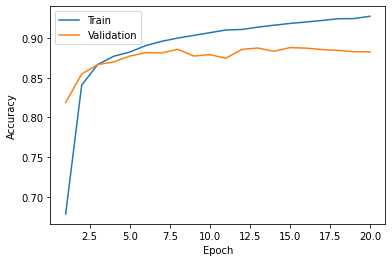

Final Training Accuracy: 0.9273582175925926
Final Validation Accuracy: 0.8824074074074074


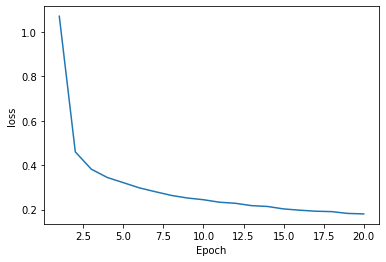

In [ ]:
model = PlateNet2_noDO()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=100, learning_rate=0.0015, num_epochs=20)

cuda
Epoch 1: Train acc: 0.697019675925926, Train loss: 0.9756676977597221 |Validation acc: 0.8467013888888889
Epoch 2: Train acc: 0.8255787037037037, Train loss: 0.5136687681294245 |Validation acc: 0.8623263888888889
Epoch 3: Train acc: 0.8473668981481481, Train loss: 0.4356663438970643 |Validation acc: 0.8885416666666667
Epoch 4: Train acc: 0.8610532407407407, Train loss: 0.39242808983763516 |Validation acc: 0.885474537037037
Epoch 5: Train acc: 0.8701533564814815, Train loss: 0.36453148627901355 |Validation acc: 0.8929976851851852
Epoch 6: Train acc: 0.8747395833333333, Train loss: 0.3455855617934913 |Validation acc: 0.8909722222222223
Epoch 7: Train acc: 0.8801938657407408, Train loss: 0.32587546353481406 |Validation acc: 0.8943865740740741
Epoch 8: Train acc: 0.8845775462962963, Train loss: 0.31346535189561764 |Validation acc: 0.9000578703703703
Epoch 9: Train acc: 0.8873842592592592, Train loss: 0.30404016889114943 |Validation acc: 0.8954282407407408
Epoch 10: Train acc: 0.889250

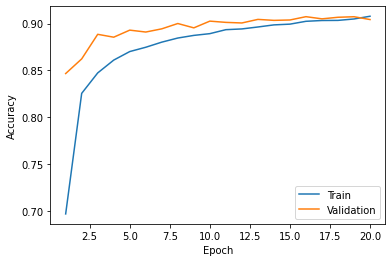

Final Training Accuracy: 0.9078125
Final Validation Accuracy: 0.9042824074074074


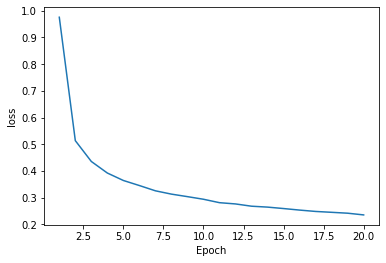

In [ ]:
## BEST ONE SO FAR
model = PlateNet2()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=100, learning_rate=0.0015, num_epochs=20)

cuda
Epoch 1: Train acc: 0.6665075231481481, Train loss: 1.0717164442115437 |Validation acc: 0.8391782407407408
Epoch 2: Train acc: 0.8345341435185185, Train loss: 0.46649304518982165 |Validation acc: 0.8651620370370371
Epoch 3: Train acc: 0.8578414351851852, Train loss: 0.3888196306292377 |Validation acc: 0.8837962962962963
Epoch 4: Train acc: 0.8703993055555556, Train loss: 0.35239487434225963 |Validation acc: 0.8842013888888889
Epoch 5: Train acc: 0.8785734953703703, Train loss: 0.3253007915538515 |Validation acc: 0.8914930555555556
Epoch 6: Train acc: 0.8856915509259259, Train loss: 0.30388077562728716 |Validation acc: 0.8934027777777778
Epoch 7: Train acc: 0.8912760416666666, Train loss: 0.2907801019404665 |Validation acc: 0.8994791666666667
Epoch 8: Train acc: 0.8947916666666667, Train loss: 0.27679859174986104 |Validation acc: 0.8985532407407407
Epoch 9: Train acc: 0.8974826388888889, Train loss: 0.2634822140431645 |Validation acc: 0.8986111111111111
Epoch 10: Train acc: 0.89986

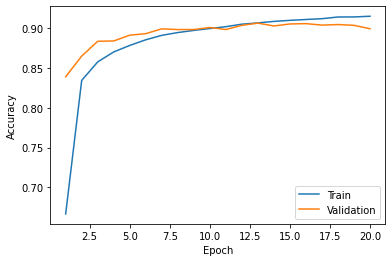

Final Training Accuracy: 0.9153211805555556
Final Validation Accuracy: 0.8995949074074074


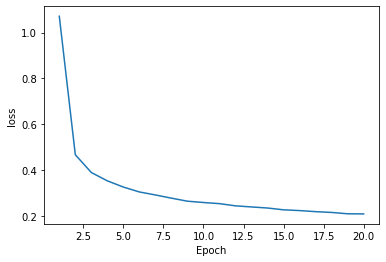

In [ ]:
model = PlateNet3()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=100, learning_rate=0.0015, num_epochs=20)

cuda
Epoch 1: Train acc: 0.6133680555555555, Train loss: 1.2706871795430348 |Validation acc: 0.8251157407407408
Epoch 2: Train acc: 0.7881076388888889, Train loss: 0.6349766204036729 |Validation acc: 0.8578703703703704
Epoch 3: Train acc: 0.8147424768518519, Train loss: 0.5456132259585954 |Validation acc: 0.8623263888888889
Epoch 4: Train acc: 0.8273003472222222, Train loss: 0.49957500484292905 |Validation acc: 0.8717592592592592
Epoch 5: Train acc: 0.8371383101851851, Train loss: 0.4678957159765538 |Validation acc: 0.8741319444444444
Epoch 6: Train acc: 0.844921875, Train loss: 0.44273107976927234 |Validation acc: 0.8784143518518519
Epoch 7: Train acc: 0.8492910879629629, Train loss: 0.42987343780911724 |Validation acc: 0.8795138888888889
Epoch 8: Train acc: 0.85390625, Train loss: 0.41236243773833176 |Validation acc: 0.8822337962962963
Epoch 9: Train acc: 0.8584780092592592, Train loss: 0.39456673612484355 |Validation acc: 0.880613425925926
Epoch 10: Train acc: 0.8619502314814815, Tr

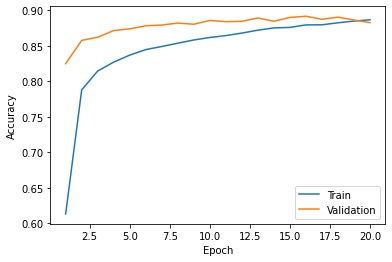

Final Training Accuracy: 0.8869212962962963
Final Validation Accuracy: 0.8829282407407407


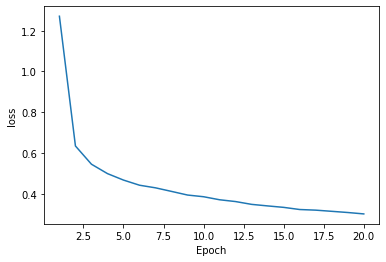

In [ ]:
model = PlateNet4()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=100, learning_rate=0.0015, num_epochs=20)

cuda
Epoch 1: Train acc: 0.556004050925926, Train loss: 1.4942039822395137 |Validation acc: 0.7867476851851852
Epoch 2: Train acc: 0.7548755787037037, Train loss: 0.737131918096818 |Validation acc: 0.8349537037037037
Epoch 3: Train acc: 0.7920717592592592, Train loss: 0.6237294390108544 |Validation acc: 0.8505787037037037
Epoch 4: Train acc: 0.8088831018518519, Train loss: 0.5613672031746434 |Validation acc: 0.8644097222222222
Epoch 5: Train acc: 0.8210069444444444, Train loss: 0.5187344665644485 |Validation acc: 0.8652777777777778
Epoch 6: Train acc: 0.833738425925926, Train loss: 0.48321390849661966 |Validation acc: 0.8732060185185185
Epoch 7: Train acc: 0.8398003472222222, Train loss: 0.4629899990997907 |Validation acc: 0.8766782407407407
Epoch 8: Train acc: 0.8458188657407407, Train loss: 0.4439000702662275 |Validation acc: 0.8796875
Epoch 9: Train acc: 0.8507667824074074, Train loss: 0.42272905164500535 |Validation acc: 0.8822337962962963
Epoch 10: Train acc: 0.8534143518518519, T

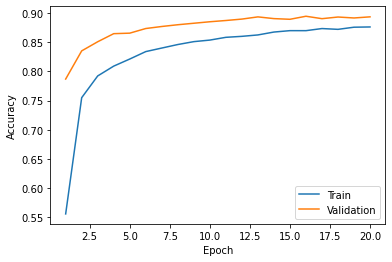

Final Training Accuracy: 0.8758825231481482
Final Validation Accuracy: 0.8931712962962963


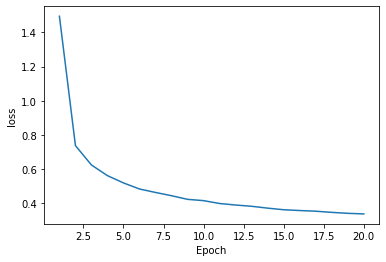

In [ ]:
model = PlateNet2()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=100, learning_rate=0.001, num_epochs=20)

cuda
Epoch 1: Train acc: 0.5378761574074075, Train loss: 1.5577844450239502 |Validation acc: 0.7892939814814814
Epoch 2: Train acc: 0.762572337962963, Train loss: 0.7196947245756325 |Validation acc: 0.8347222222222223
Epoch 3: Train acc: 0.7989438657407407, Train loss: 0.5927142281235988 |Validation acc: 0.8569444444444444
Epoch 4: Train acc: 0.8200810185185186, Train loss: 0.527832024100888 |Validation acc: 0.8699652777777778
Epoch 5: Train acc: 0.8319878472222222, Train loss: 0.4822406659408801 |Validation acc: 0.8708912037037037
Epoch 6: Train acc: 0.8418692129629629, Train loss: 0.4556586364273391 |Validation acc: 0.8826967592592593
Epoch 7: Train acc: 0.8476128472222222, Train loss: 0.43480619512541446 |Validation acc: 0.882349537037037
Epoch 8: Train acc: 0.8511284722222222, Train loss: 0.42162947511741883 |Validation acc: 0.8848379629629629
Epoch 9: Train acc: 0.8582320601851852, Train loss: 0.4014298312925879 |Validation acc: 0.8865740740740741
Epoch 10: Train acc: 0.8607638888

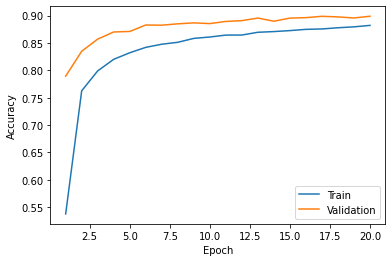

Final Training Accuracy: 0.8819733796296296
Final Validation Accuracy: 0.8986689814814814


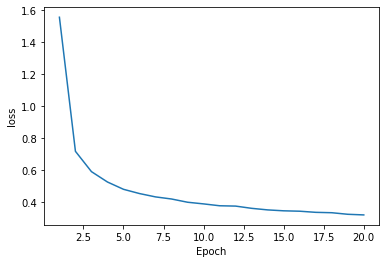

In [ ]:
model = PlateNet2()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=200, learning_rate=0.0015, num_epochs=20)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Epoch 1: Train acc: 0.6183449074074074, Train loss: 1.2569619129510867 |Validation acc: 0.8118055555555556
Epoch 2: Train acc: 0.7762008101851852, Train loss: 0.6651147889728919 |Validation acc: 0.8535879629629629
Epoch 3: Train acc: 0.8100260416666667, Train loss: 0.5591876476313529 |Validation acc: 0.858912037037037
Epoch 4: Train acc: 0.8242476851851852, Train loss: 0.5103768687143071 |Validation acc: 0.8712384259259259
Epoch 5: Train acc: 0.8353877314814815, Train loss: 0.4792783696390284 |Validation acc: 0.8769097222222222
Epoch 6: Train acc: 0.8417245370370371, Train loss: 0.45236451561823326 |Validation acc: 0.8818287037037037
Epoch 7: Train acc: 0.8493344907407407, Train loss: 0.42557252352533353 |Validation acc: 0.8835648148148149
Epoch 8: Train acc: 0.8537181712962963, Train loss: 0.40957724928468014 |Validation acc: 0.8868634259259259
Epoch 9: Train acc: 0.8593026620370371, Train loss: 0.396940241181928 |Validation a

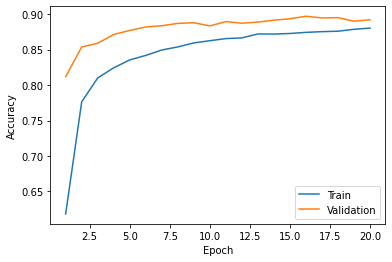

Final Training Accuracy: 0.880222800925926
Final Validation Accuracy: 0.8919560185185185


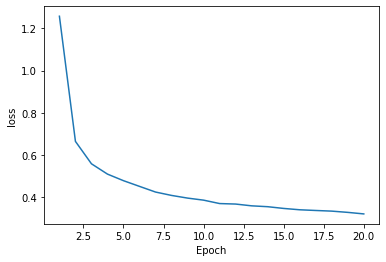

In [ ]:
model = PlateNet2()
if torch.cuda.is_available():
    model = model.cuda()
    print("cuda")
training(model, batch_size=50, learning_rate=0.0015, num_epochs=20)

In [ ]:
model = PlateNet2()
state = torch.load("model_platenet2_bs50_lr0.0015",map_location = "cpu")
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
test_loader = get_test_loader(1)
test_acc = get_acc_loss(test_loader, model)

In [ ]:
print(test_acc)

0.9059027777777777


In [ ]:
from PIL import Image
img = Image.open("/content/drive/MyDrive/ML-AI Project/28by28/01334X2/ROI_1.png")

img


In [ ]:
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)
# convert_tensor(img)

In [ ]:
model = PlateNet2()
###### Best so far
# state = torch.load("model_platenet2_bs100_lr0.0015",map_location = torch.device('cpu'))

model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
output = model(img)
pred = output.max(1, keepdim=True)[1]

In [ ]:
print(pred.item())
target[pred]

21


'L'

In [ ]:
folder_path = r"/content/drive/MyDrive/ML-AI Project/28by28"

plate_dic = {}
for folder in os.listdir(folder_path):

    plate_path = os.path.join(folder_path,folder)
    filenames = os.listdir(plate_path)
    filenames.sort()
    plate_dic[folder] = filenames
print(plate_dic)


{'TDL6006': ['ROI_3.png', 'ROI_4.png', 'ROI_5.png', 'ROI_6.png', 'ROI_7.png', 'ROI_8.png', 'ROI_9.png'], 'SCARPY': ['ROI_0.png', 'ROI_1.png', 'ROI_2.png', 'ROI_3.png', 'ROI_4.png', 'ROI_5.png'], 'VUI159': ['ROI_1.png', 'ROI_2.png', 'ROI_3.png', 'ROI_6.png', 'ROI_7.png', 'ROI_8.png'], '2A00315': ['ROI_0.png', 'ROI_1.png', 'ROI_2.png', 'ROI_3.png', 'ROI_4.png', 'ROI_5.png', 'ROI_6.png'], '215557W': ['ROI_1.png', 'ROI_2.png', 'ROI_3.png', 'ROI_4.png', 'ROI_5.png', 'ROI_6.png', 'ROI_7.png'], '01334X2': ['ROI_0.png', 'ROI_1.png', 'ROI_2.png', 'ROI_3.png', 'ROI_4.png', 'ROI_5.png', 'ROI_6.png'], '73309E2': ['ROI_3.png', 'ROI_4.png', 'ROI_5.png', 'ROI_6.png', 'ROI_7.png', 'ROI_8.png', 'ROI_9.png'], '1MA625': ['ROI_1.png', 'ROI_2.png', 'ROI_3.png', 'ROI_4.png', 'ROI_5.png', 'ROI_6.png'], '4686BH5': ['ROI_1.png', 'ROI_2.png', 'ROI_4.png', 'ROI_6.png', 'ROI_7.png', 'ROI_8.png', 'ROI_9.png'], 'PMF242': ['ROI_1.png', 'ROI_2.png', 'ROI_3.png', 'ROI_4.png', 'ROI_5.png', 'ROI_6.png'], '.ipynb_checkpo

In [ ]:
correct = 0
total = 0
for i in plate_dic:
  prediction = ''
  for j in range(len(plate_dic[i])):
    plate_path = os.path.join(folder_path,i)
    img_path = os.path.join(plate_path,plate_dic[i][j])
    img = Image.open(img_path)
    convert_tensor = transforms.ToTensor()
    img = convert_tensor(img)
    model.eval()
    output = model(img)
    pred = output.max(1, keepdim=True)[1].item()
    print(target[pred],i[j])
    if str(target[pred]) == str(i[j]):
      correct +=1
    total += 1
print(f"Predicted {correct} correctly")
print(f"Made a total of {total} values")
print(f"Accuracy is {correct/total}")

T T
B D
L L
G 6
8 0
D 0
B 6
S S
C C
A A
R R
P P
Y Y
Y V
U U
J I
I 1
5 5
9 9
Z 2
A A
B 0
B 0
3 3
L 1
5 5
2 2
1 1
5 5
5 5
5 5
7 7
H W
B 0
I 1
3 3
3 3
6 4
X X
Z 2
7 7
3 3
3 3
B 0
9 9
E E
Z 2
I 1
H M
B A
G 6
2 2
5 5
8 4
B 6
B 8
6 6
B B
H H
5 5
P P
H M
F F
Z 2
4 4
Z 2
Predicted 37 correctly
Made a total of 66 values
Accuracy is 0.5606060606060606
